
0.   Create subject 


1.   Flavor tasting order
    
        Creates order for flavor ratings

2.   Four flavor selection & learning A and Assoc. test A sequence generator

3.   Two flavor selection, learning B and Assoc. test B sequence generator & neuroeconomics sequence generator



# Script Prep.

In [18]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  %pip install pandas==1.4.2
  print('Running Code in Colab')
except:
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  print('Running Code locally')

import sys
sys.path.append(root + '1. Acquisition/notebooks')
sys.path.append(root + 'python')

# sys.path.append(root + '1. Acquisition/notebooks_psychophysics')

from variableCoding import Vars
import importData as load_data

from nutrecon import *

import numpy as np
from glob import glob
from datetime import datetime
import json

from random import shuffle, sample
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

_v_ = Vars()

# experiment_code = _v_.experiment_code
# dataPath = _v_.dataPath
# sequences_dataPath = _v_.sequences_dataPath
# responses_dataPath = _v_.responses_dataPath

# flavorCodes = _v_.flavorCodes

# imageCodes = _v_.imageCodes

# imageDecoder = _v_.imageDecoder

# pres_order_fileID = _v_.pres_order_fileID
# pres_order_colName = _v_.pres_order_colName
# flavorName_colName = _v_.flavorName_colName
# flavorID_colName = _v_.flavorID_colName

# pres_order_d2_fileID = _v_.pres_order_d2_fileID
# pres_order_d3_fileID = _v_.pres_order_d3_fileID

# flav_ratings_fileID = _v_.flav_ratings_fileID

# intensity_colName = _v_.intensity_colName
# novelty_colName = _v_.novelty_colName
# pleasanteness_colName = _v_.pleasanteness_colName

# learn_order_fileID = _v_.learn_order_fileID
# learningOrder_colName = _v_.learningOrder_colName
# imageName_colName = _v_.imageName_colName
# imageID_colName = _v_.imageID_colName

# assocTestOrder1_colName = _v_.assocTestOrder1_colName
# assoc1_order_fileID = _v_.assoc1_order_fileID

# assocTestOrder2_colName = _v_.assocTestOrder2_colName
# assoc2_order_fileID = _v_.assoc2_order_fileID

# assocTestOrder3_colName = _v_.assocTestOrder3_colName
# assoc3_order_fileID = _v_.assoc3_order_fileID

# neuroEconOrder0_fileID = _v_.neuroEconOrder0_fileID
# neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
# neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

# neuroEcon_responses_fileID = _v_.neuroEcon_d1_responses_fileID
# neurEconRealization1_fileID = _v_.neurEconRealization_d1_fileID


# conditioning_order_fileID = _v_.conditioning_order_fileID
# conditioning_order_colName = _v_.conditioning_order_colName


Running Code locally


___

# 0. Create subject


In [19]:
subject_nr = 21

subject_code = '{}{:03d}'.format(_v_.experiment_code, subject_nr)

timestamp = datetime.now().timestamp()
print(subject_code)

nutre021


# 1. Flavor tasting order 

In [20]:
# Create a list called "flavorList" by extracting the keys from the "_v_.flavorCodes" dictionary object.
flavorList = list(_v_.flavorCodes.keys()) 
# Shuffle the order of flavors in "flavorList" randomly.
shuffle(flavorList) 

# Create a nested list called "presentation_order_list" by iterating through flavors in "flavorList" 
# Each sublist contains the order, the flavor itself and the flavor_id
presentation_order_list = [[p + 1, flavorList[p], _v_.flavorCodes[flavorList[p]]] for p in range(len(flavorList))] 
presentation_order_df = pd.DataFrame(presentation_order_list, columns = [_v_.pres_order_colName, _v_.flavorName_colName, _v_.flavorID_colName]).set_index(_v_.pres_order_colName) 

# Save presentation order
presentation_order_df = save_json(presentation_order_df, subject_code, _v_.pres_order_fileID, _v_.sequences_dataPath) #

presentation_order_df # Print out "presentation_order_df".

File already exists. Created on 2023-05-11 10:12:49


,Flavor,flavor_id
Presentation Order,,
1,lychee,d
2,grapefruit,j
3,licorice,k
4,ginseng,i
5,pomegranate,e
6,cashew,c
7,blueberry,g
8,dragon fruit,h


# 2. Four flavor selection & learning A and Assoc. test A sequence generator

## 2.1 Flavor Ratings


In [21]:
def selectFlavorsForAssociationTest(df, col_name):

    # in any of the bellow options, if flavors are tied for pleasantness, first choose least intense and then most novel

    # Select rows with pleasantness between 0 and 80
    df_sel = df[(df[col_name] > 0) & (df[col_name] <= 80)]

    flavors_in_criteria = list(df_sel.sort_values(by=[_v_.pleasanteness_colName, _v_.intensity_colName, _v_.novelty_colName], 
                                                    ascending=[False, True, False])[_v_.flavorName_colName])

    # Check if we have 4 flavors that comply with the above criteria
    if len(flavors_in_criteria) >=4:
        print('Enough flavors in Criteria')
        selected_flavors = flavors_in_criteria[:4]
    # if not, fill with other flavors
    else:
        # first with flavors above 80 (those closest to 80)
        above80 = df[(df[col_name] > 80)]
        flavors_above80 = list(above80.sort_values(by=[col_name], ascending=[True, True, False])[_v_.flavorName_colName])
        # Check if enough flaours to reach 4
        if len(flavors_above80) >= 4-len(flavors_in_criteria):
            selected_flavors = flavors_in_criteria + flavors_above80[:4-len(flavors_in_criteria)]
        else:
            #if not enough, with flavors below zero (those closest to zero)
            below0 = df[(df[col_name] <= 0)]
            flavors_below0 = list(below0.sort_values(by=[_v_.pleasanteness_colName, _v_.intensity_colName, _v_.novelty_colName], 
                                                    ascending=[False, True, False])[_v_.flavorName_colName])
            selected_flavors = flavors_in_criteria + flavors_above80[:4-len(flavors_in_criteria)] + flavors_below0[:4-len(flavors_in_criteria) - len(flavors_above80)]

    df['selected'] = np.where(df[_v_.flavorName_colName].isin(selected_flavors), 'selected', 'not selected')
    df.set_index('selected', inplace=True)
    df.sort_index(inplace = True, ascending = False)
    return df


df_pleas = None
df_pleas_ = None

ratings_colNames = ['User','Trial',_v_.novelty_colName, _v_.intensity_colName, _v_.pleasanteness_colName]
df_, _ = loadResponses(_v_.responses_dataPath, _v_.flav_ratings_fileID, subject_code)

if not df_ is None: # responses exist
  # merge ratings with presentation order to match flavors with trials
  df_pleas = presentation_order_df.reset_index().merge(df_[ratings_colNames],
                                    left_on = _v_.pres_order_colName, right_on = 'Trial').drop(columns='Trial')
  # Select 4 flavors
  df_pleas = selectFlavorsForAssociationTest(df_pleas, _v_.pleasanteness_colName)


df_pleas.drop(columns = ['User',_v_.pres_order_colName] )

Enough flavors in Criteria


,Flavor,flavor_id,novelty,intensity,pleasantness
selected,,,,,
selected,grapefruit,j,72,26,55
selected,ginseng,i,88,29,44
selected,pomegranate,e,0,32,44
selected,dragon fruit,h,11,30,44
not selected,lychee,d,34,11,-6
not selected,licorice,k,7,29,-18
not selected,cashew,c,12,31,26
not selected,blueberry,g,49,10,0


## 2.2 Learning Order

### Select four flavors below

In [22]:
four_flavors = ['j','h','i','e']   # CHANGE HERE

#===============================================================================

def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

images = sample(_v_.imageCodes.keys(),4)

imageFlavor_list = [[get_key(_v_.flavorCodes, four_flavors[p]), 
                     _v_.imageCodes[images[p]],
                     four_flavors[p], images[p]] for p in range(len(four_flavors))]

imageFlavor_df = pd.DataFrame(imageFlavor_list, columns = [_v_.flavorName_colName, _v_.shapeName_colName,
                                                           _v_.flavorID_colName, _v_.shapeID_colName])

imageFlavor_df = imageFlavor_df.sample(frac= 1).reset_index(drop = True)
imageFlavor_df.index += 1
imageFlavor_df.index.name = _v_.learningOrder_colName


imageFlavor_df = save_json(imageFlavor_df, subject_code, _v_.learn_order_fileID, _v_.sequences_dataPath)
flavorImage_code = {p[_v_.shapeID_colName]:p[_v_.flavorName_colName] for p in imageFlavor_df[[_v_.shapeID_colName, _v_.flavorName_colName]].to_dict('index').values()}

imageFlavor_df.drop(columns = [_v_.flavorName_colName, _v_.shapeName_colName])


C:\Users\Admin\AppData\Local\Temp\ipykernel_12700\2089111879.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images = sample(_v_.imageCodes.keys(),4)


,flavor_id,shape_id
Learning order,,
1,h,Image VI
2,i,Image II
3,e,Image V
4,j,Image I


## 2.3 Association Test A order

In [24]:
associationTest1_df = pd.concat([imageFlavor_df]*6).sample(frac = 1).reset_index(drop = 'False')
associationTest1_df.index += 1
associationTest1_df.index.name = _v_.assocTestOrder1_colName

associationTest1_df = save_json(associationTest1_df, subject_code, _v_.assoc1_order_fileID, _v_.sequences_dataPath)
associationTest1_df.drop(columns = [_v_.flavorName_colName, _v_.shapeName_colName])

,flavor_id,shape_id
Day 1 - Association Test order,,
1,e,Image V
2,i,Image II
3,i,Image II
4,e,Image V
5,j,Image I
6,h,Image VI
7,i,Image II
8,j,Image I
9,h,Image VI


## Ratings 2 Order

In [8]:
four_flavor_names = [list({i for i in _v_.flavorCodes if _v_.flavorCodes[i]==p})[0]  for p in four_flavors]


# Shuffle the order of flavors in "flavorList" randomly.
shuffle(four_flavor_names) 

# Create a nested list called "presentation_order_list" by iterating through flavors in "flavorList" 
# Each sublist contains the order, the flavor itself and the flavor_id
presentation_order2_list = [[p + 1, flavorList[p], _v_.flavorCodes[flavorList[p]]] for p in range(len(flavorList))] 
presentation_order2_df = pd.DataFrame(presentation_order_list, columns = [_v_.pres_order_colName, _v_.flavorName_colName, _v_.flavorID_colName]).set_index(_v_.pres_order_colName) 

# Save presentation order
presentation_order2_df = save_json(presentation_order_df, subject_code, _v_.pres_order_d1_2_fileID, _v_.sequences_dataPath) #

presentation_order2_df # Print out "presentation_order_df".

File already exists. Created on 2023-05-11 02:47:59


,Flavor,flavor_id
1,dragon fruit,h
2,licorice,k
3,pomegranate,e
4,cashew,c
5,grapefruit,j
6,ginseng,i
7,blueberry,g
8,lychee,d


# 3. Two flavor selection & Assoc. test B  and neuroeconomics sequence generator

## 3.1 Flavor selection
### is it associated?

			Accuracy: 0.9166666666666666


precision    recall  f1-score      Flavor
criteria      shape_id flavor_id                                           
in compliance Image I  k           1.000000  1.000000  1.000000    licorice
              Image VI c           1.000000  1.000000  1.000000      cashew
              Image II i           0.833333  0.833333  0.833333     ginseng
              Image V  j           0.833333  0.833333  0.833333  grapefruit

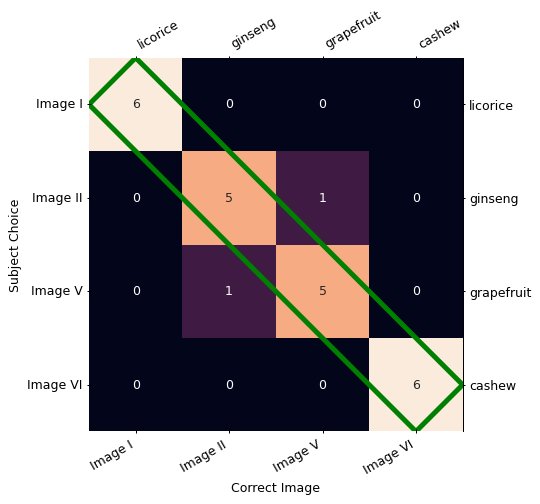

In [9]:
min_correctResp = 4

atest_day1_sequence = [get_key(_v_.imageDecoder,p) for p in associationTest1_df[_v_.shapeID_colName].tolist()]
atest_day1_responses, _ = loadResponses(_v_.responses_dataPath, 'day1_atest', subject_code)
fig, report = reportAndConfusionMatrix(atest_day1_sequence, atest_day1_responses[_v_.shapeID_colName].tolist(), flavorImage_code)
aTest_report_df = check_atest(report, flavorImage_code, min_correctResp)

AssociatedFlavors = list(aTest_report_df.iloc[
    aTest_report_df.index.get_level_values('criteria') == 'in compliance'].reset_index()[_v_.flavorID_colName])
aTest_report_df

### Are there two above 0 pleasantness

In [10]:
df_pleas2 = None

df_, _ = loadResponses(_v_.responses_dataPath, _v_.flav_ratings_d1_2_fileID, subject_code)

if not df_ is None: # responses exist
  # merge ratings with presentation order to match flavors with trials
  df_pleas2 = presentation_order_df.reset_index().merge(df_[ratings_colNames],
                                    left_on = _v_.pres_order_colName, right_on = 'Trial').drop(columns='Trial')
  df_pleas2 = df_pleas2[df_pleas2[_v_.pleasanteness_colName] > 0]

df_pleas2

No file found for this subject.


### Select most similar according to pleasantness and most pleasant pair

In [12]:
def get_distance_df(df_pleas, AssociatedFlavors):

    tmp = df_pleas[df_pleas[_v_.flavorID_colName].isin(AssociatedFlavors)]

    # euclidean_dist = pdist(tmp[[_v_.pleasanteness_colName,_v_.intensity_colName]].values, 'euclidean')
    indices = [(i,j) for i in range(len(tmp)) for j in range(len(tmp)) if i<j]
    distance_Pairs = [['{} ({}) - {} ({})'.format(tmp[_v_.flavorName_colName].iloc[ind[0]], tmp[_v_.flavorID_colName].iloc[ind[0]],
                                                tmp[_v_.flavorName_colName].iloc[ind[1]], tmp[_v_.flavorID_colName].iloc[ind[1]]),
    abs(tmp[_v_.pleasanteness_colName].iloc[ind[0]] - 
                        tmp[_v_.pleasanteness_colName].iloc[ind[1]]),
    tmp[_v_.pleasanteness_colName].iloc[ind[0]] + 
                        tmp[_v_.pleasanteness_colName].iloc[ind[1]]] for ind in indices]

    distance_df = pd.DataFrame(distance_Pairs, columns=[_v_.flavorName_colName, 'Pleas Dist', 'Pleas Sum']
                               ).sort_values(by=['Pleas Dist', 'Pleas Sum'], ascending= [True,False])
    return distance_df

distance_df = get_distance_df(df_pleas2, AssociatedFlavors)
distance_df

,Flavor,Pleas Dist,Pleas Sum
1,licorice (k) - ginseng (i),0,88
2,licorice (k) - grapefruit (j),0,88
5,ginseng (i) - grapefruit (j),0,88
0,licorice (k) - cashew (c),22,110
3,cashew (c) - ginseng (i),22,110
4,cashew (c) - grapefruit (j),22,110


### If several are tied on top, random selection



In [70]:
import random

tmp = distance_df[(distance_df['Pleas Dist'] == distance_df['Pleas Dist'].min())]
tmp = list(tmp[(tmp['Pleas Sum'] == tmp['Pleas Sum'].max())][_v_.flavorName_colName])

random.choice(tmp)

'licorice (k) - grapefruit (j)'

### Select two flavors below

In [13]:
two_flavors = ['c', 'e']

#### Generate sequences for the rest od the expetiment

In [14]:
presentation_order_d2_df = imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1).reset_index(drop = True)
presentation_order_d2_df.index.name = _v_.pres_order_colName
presentation_order_d2_df = save_json(presentation_order_d2_df, subject_code, _v_.pres_order_d2_fileID, _v_.sequences_dataPath)
presentation_order_d3_df = imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1).reset_index(drop = True)
presentation_order_d3_df.index.name = _v_.pres_order_colName
presentation_order_d3_df = save_json(presentation_order_d3_df, subject_code, _v_.pres_order_d3_fileID, _v_.sequences_dataPath)


File already exists. Created on 2023-03-02 10:44:11
File already exists. Created on 2023-03-02 10:44:11


# DO THIS!!

In [ ]:
def get_quantities(central_value, round_by):
    list_qts = [round(central_value*0.88, round_by),
            round(central_value*0.92, round_by),
            round(central_value*0.96, round_by),
            round(central_value*1, round_by),
            round(central_value*1.04, round_by),
            round(central_value*1.08, round_by),
            round(central_value*1.12, round_by)]
    return list_qts

def get_quantities_last(central_value, round_by):
    list_qts = [round(central_value*0.87, round_by),
            round(central_value*0.89, round_by),
            round(central_value*0.91, round_by),
            round(central_value*.94, round_by),
            round(central_value*.96, round_by),
            round(central_value*.98, round_by),
            round(central_value*1, round_by)]
    return list_qts

st_yogurt20_lottQs = [20]*7
st_yogurt40_lottQs = get_quantities(40, 0)
st_yogurt80_lottQs = get_quantities(80, 0) 
st_yogurt120_lottQs = get_quantities_last(120, 0)

st_money2_lottQs = [2]*7
st_money5_lottQs = get_quantities(5, 1)
st_money12_lottQs = get_quantities(12, 1)
st_money20_lottQs = get_quantities_last(20, 1)

# Same-type & mixed type Trials Lottery probabilities
st_refPs = [1]                              # Reference option
st_lottPs = [0.13, 0.22, 0.38, .50, .75]    # Lottery option

# Same-type task variables
st_money_refQs = [2]                               # Euros
st_money_lottQs = st_money2_lottQs + st_money5_lottQs + st_money12_lottQs + st_money20_lottQs                # Euros

st_cPlus_refQs = [20]                              # mL of CS+ yogurt 
st_cPlus_lottQs = st_yogurt20_lottQs + st_yogurt40_lottQs + st_yogurt80_lottQs +  st_yogurt120_lottQs           # mL of CS+ yogurt

st_cMinus_refQs = st_cPlus_refQs                      # mL of CS- yogurt 
st_cMinus_lottQs = st_cPlus_lottQs                    # mL of CS- yogurt 

# Mixed-type task variables
mt_refQs = [.2]                                # Euros
mt_refPs = [1]
mt_lottPs = [0.13, 0.22, 0.38, .50, .75]

mt_cPlus_lottQs = st_cPlus_lottQs      # mL of CS+ yogurt 
mt_cMinus_lottQs = mt_cPlus_lottQs            # mL of CS- yogurt 

import nutrecon_simulation as sim

allTrials_df = sim.pack_taskParameters(
                st_refPs, st_lottPs, st_money_refQs, st_money_lottQs, st_cPlus_refQs, st_cPlus_lottQs,
                st_cMinus_refQs, st_cMinus_lottQs, mt_refQs, mt_refPs, mt_lottPs, mt_cPlus_lottQs,
                mt_cMinus_lottQs, 1)

allTrials_list = allTrials_df.replace('Money', 'money').values.tolist()

# MIXED YOGURT TRIALS
allTrials_list += [['mixed_yogurt', 'C+', 40, .75, 'C-', 40, 0.75]] * 7 # Low-High / Low-High
allTrials_list += [['mixed_yogurt', 'C+', 120, .13, 'C-', 120, .13]] * 7 # High-Low / High-Low
allTrials_list += [['mixed_yogurt', 'C+', 40, .75, 'C-', 120, 0.13]] * 7 # Low-High / High-Low
allTrials_list += [['mixed_yogurt', 'C+', 120, .13, 'C-', 40, .75]] * 7 # High-Low / Low-High
allTrials_list += [['mixed_yogurt', 'C+', 80, .5, 'C-', 80, 0.5]] * 7 # Med-Med / Med-Med

In [ ]:
_, cPlus, cMinus = generate_NeuroeconomicsTrials(allTrials_list, two_flavors, subject_code, _v_.neuroEconOrder0_fileID, _v_.sequences_dataPath, df_pleas, flavorImage_code, mixed_blocks = True, n_Lott_reps = 1);

_, cPlus, cMinus = generate_NeuroeconomicsTrials(allTrials_list, two_flavors, subject_code, _v_.neuroEconOrder1_fileID, _v_.sequences_dataPath, df_pleas, flavorImage_code, mixed_blocks = True, flavors = (cPlus, cMinus), n_Lott_reps = 1 );
_, cPlus, cMinus = generate_NeuroeconomicsTrials(allTrials_list, two_flavors, subject_code, _v_.neuroEconOrder2_fileID, _v_.sequences_dataPath, df_pleas, flavorImage_code, mixed_blocks = True, flavors = (cPlus, cMinus), n_Lott_reps = 1 );

print()
print('=' * 50)
print('\t\tC+ -> {}\n\t\tC- -> {}'.format(cPlus, cMinus))
print()

conditioning_order_df = pd.concat(2*[imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1)]).reset_index(drop = True)
conditioning_order_df.index.name = _v_.conditioning_order_colName
conditioning_order_df.index += 1
conditioning_order_df = save_json(conditioning_order_df, subject_code, _v_.conditioning_order_fileID, _v_.sequences_dataPath)
conditioning_order_df


# 4. Reward realization (day 1)

In [13]:

df, responses_path = loadResponses(_v_.responses_dataPath, _v_.neuroEcon_responses_fileID, subject_code)

seed = int(responses_path.split('_')[-1].split('.')[0])
rng = np.random.default_rng(int(responses_path.split('_')[-1].split('.')[0]))

df_clean = df[df['choice'] != 0]

mix_yogurt_df = df_clean[df_clean['Trial Type'] == 'mixed_yogurt']
st_mt_df = df_clean[df_clean['Trial Type'] != 'mixed_yogurt']

realizationTrials_df  = pd.concat([mix_yogurt_df.sample(1), st_mt_df.groupby(['Trial Type', 'lottery type']).sample(1)]).reset_index(drop = True)

realizationResults_df = realizationTrials_df.apply(lambda row: realizeChoices(row,rng), axis = 1)
realizationResults_df = save_json(realizationResults_df, subject_code, _v_.neurEconRealization1_fileID , _v_.sequences_dataPath)
realizationResults_df[['Trial Type', 'reference type', 'lottery type', 'reference qt', 'lottery qt', 'reference p', 'lottery p', 'choice', 'reward Qt.',	'reward description']]

,Trial Type,reference type,lottery type,reference qt,lottery qt,reference p,lottery p,choice,reward Qt.,reward description
0,mixed_yogurt,C+,C-,40.0,120,0.75,0.13,1,40.0,mL of pomegranate yogurt
1,mixed,money,C+,0.2,80,1.00,0.22,2,0.0,You got nothing
2,mixed,money,C-,0.2,40,1.00,0.22,1,0.2,€
3,same,C+,C+,20.0,200,1.00,0.22,2,0.0,You got nothing
4,same,C-,C-,20.0,120,1.00,0.13,2,0.0,You got nothing
5,same,money,money,1.0,2,1.00,0.22,1,1.0,€
